### Imports

In [1]:
import numpy as np
import pandas as pd
from stratmanager import StrategyManager
import sklearn.mixture as mix
from ta.momentum import RSIIndicator
import matplotlib.pyplot as plt

### Data Extraction and Returns Overview

In [2]:
# Extract Data
start_date = "2017-01-01"
end_date = "2022-06-01"
symbol = "BTC-USD"
strategy_mgr = StrategyManager(symbol, start_date, end_date)
# data = self._structure_df(data)
df = strategy_mgr.df.copy()
df.head()

/home/mahan-maalekian/projects/MLTrading/CODE/2_Supervised/stratmanager.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start_date, end_date, group_by="Ticker")
[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets
Date,,,,,,,,
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992,0.023464,0.034803,0.023314
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000,0.021620,0.022005,0.045999
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984,0.106233,0.110130,0.159122
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008,-0.122410,0.308302,0.018098
2017-01-06,1014.239990,1046.810059,883.943970,902.200989,351876000,-0.109711,0.184249,-0.092307


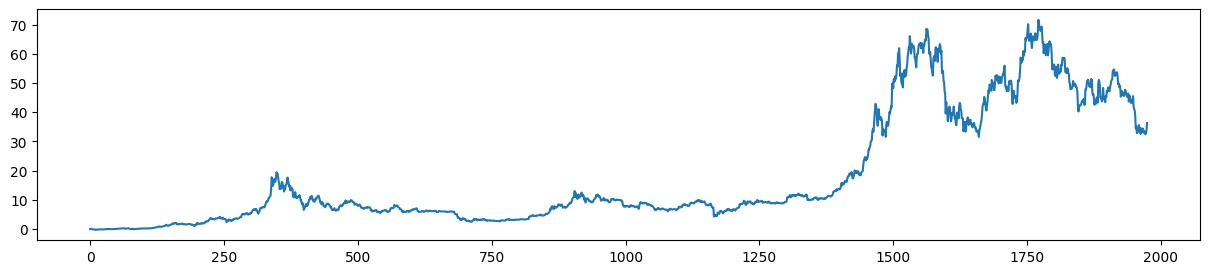

In [3]:
# Benchmark Returns Profile
fig = plt.figure(figsize=(15,3))
plt.plot(df["Bench_C_Rets"].values)

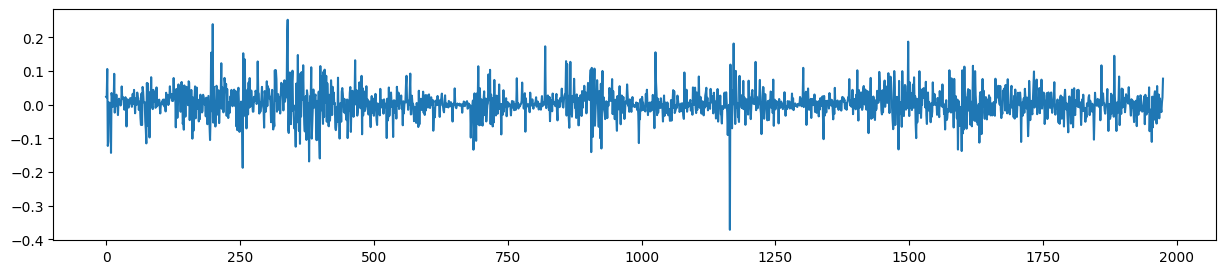

In [4]:
# Benchmark Returns Profile
fig = plt.figure(figsize=(15,3))
plt.plot(df["Returns"].values)
plt.show()

As you can see above, the cumulative returns is not stationary, but the returns are, so it is more suitable to feed into a ML model.

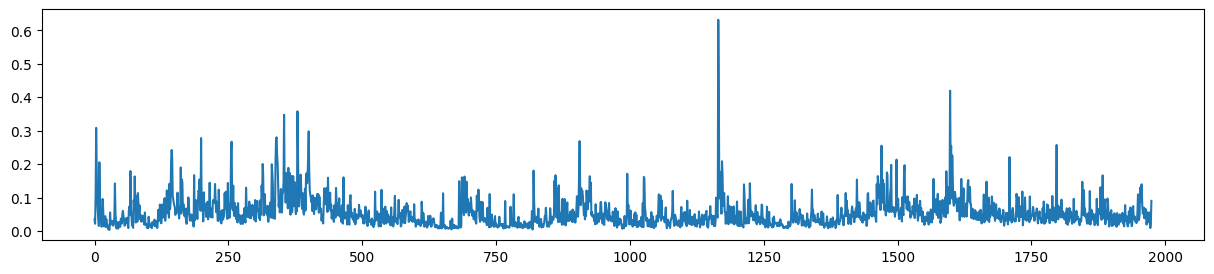

In [5]:
# Benchmark Range Profile
fig = plt.figure(figsize=(15,3))
plt.plot(df["Range"].values)
plt.show()

### Feature Engineering - Feature Expansion

In [6]:
# Create a copy
df_fe = df.copy()

##### Indicators
We are not sure yet whether these indicators will be useful or not. Our ML model will tell us this later on

Relative Strength Index is a  momentum indicator that measures the speed and magnitude of a security's recent price changes to detect overbought or oversold conditions in the price of the security. Overbought and oversold conditions exist when an asset's price has made an extreme move in one direction meaning it is likely to be mean corrected: go back to the mean. With the RSI, which oscillates between 0 and 100, 70 is considered the default overbought threshold and 30 the oversold threshold. RSI is calculated by the average size of price gains on up days and declines on down days over a set period. RS = average gain over a specified period divided by average loss over a specified period. `RSI=100−(100/1+RS)`

In [7]:
# Add RSI
rsi = RSIIndicator(close=df_fe["Close"], window=14).rsi()
df_fe["RSI"] = rsi
df_fe["RSI_Ret"] =df_fe["RSI"] / df_fe["RSI"].shift(1)

In [8]:
# Add Moving Averages
df_fe["MA_12"] = df_fe["Close"].rolling(window=12).mean()
df_fe["MA_21"] = df_fe["Close"].rolling(window=21).mean()

In [9]:
# Day of Week
df_fe["DOW"] = df_fe.index.dayofweek

In [10]:
# Rolling Cumulative Returns
df_fe["Roll_Rets"] = df_fe["Returns"].rolling(window=30).sum()

In [11]:
# Rolling Cumulative Range
df_fe["Avg_Range"] = df_fe["Range"].rolling(window=30).mean()

##### Time Intervals

In [12]:
# Add Time Intervals
t_steps = [1,2]
t_features = ["Returns", "Range", "RSI_Ret"]
for ts in t_steps:
    for tf in t_features:
        df_fe[f"{tf}_T{ts}"] = df_fe[tf].shift(ts)

In [13]:
# Show DataFrame
df_fe.head(3)

Price,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992,0.023464,0.034803,0.023314,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000,0.021620,0.022005,0.045999,NaN,NaN,...,NaN,1,NaN,NaN,0.023464,0.034803,NaN,NaN,NaN,NaN
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984,0.106233,0.110130,0.159122,NaN,NaN,...,NaN,2,NaN,NaN,0.021620,0.022005,NaN,0.023464,0.034803,NaN


### Feature Engineering - Feature Scaling

In [14]:
# Correct for Stationarity
df_fs = df_fe.copy()
df_fs[["Open", "High", "Low", "Volume"]] = df_fs[["Open", "High", "Low", "Volume"]].pct_change()
df_fs

Price,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,NaN,NaN,NaN,1021.750000,NaN,0.023464,0.034803,0.023314,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,0.023015,0.012304,0.024980,1043.839966,-0.166604,0.021620,0.022005,0.045999,NaN,NaN,...,NaN,1,NaN,NaN,0.023464,0.034803,NaN,NaN,NaN,NaN
2017-01-04,0.022318,0.110471,0.022318,1154.729980,0.862881,0.106233,0.110130,0.159122,NaN,NaN,...,NaN,2,NaN,NaN,0.021620,0.022005,NaN,0.023464,0.034803,NaN
2017-01-05,0.107555,0.027324,-0.128287,1013.380005,0.479069,-0.122410,0.308302,0.018098,NaN,NaN,...,NaN,3,NaN,NaN,0.106233,0.110130,NaN,0.021620,0.022005,NaN
2017-01-06,-0.123183,-0.121140,-0.029078,902.200989,-0.310316,-0.109711,0.184249,-0.092307,NaN,NaN,...,NaN,4,NaN,NaN,-0.122410,0.308302,NaN,0.106233,0.110130,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-26,-0.002980,-0.010731,-0.038218,29267.224609,0.336031,-0.009984,0.055632,33.189608,38.165993,0.977232,...,30545.702009,3,-0.239867,0.057147,-0.003144,0.026300,0.993166,0.019130,0.034313,1.065192
2022-05-27,-0.010608,-0.016331,0.002290,28627.574219,-0.005230,-0.021856,0.036020,32.436595,36.240181,0.949541,...,30192.685454,4,-0.291202,0.057119,-0.009984,0.055632,0.977232,-0.003144,0.026300,0.993166
2022-05-28,-0.021487,-0.018129,0.008047,28814.900391,-0.029042,0.006544,0.009117,32.894788,37.238957,1.027560,...,29874.254371,5,-0.298233,0.056286,-0.021856,0.036020,0.949541,-0.009984,0.055632,0.977232


### Assess Data for ML Readiness

In [15]:
# Check for NaN
df_fs.dropna(inplace=True)
df_fs.isnull().values.any()

False

In [16]:
dfobj = df_fs.isin([np.inf, -np.inf])
count = np.isinf(dfobj).values.sum()
count

0

In [17]:
# Check for non-numerical objects
df_fs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1946 entries, 2017-01-31 to 2022-05-30
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1946 non-null   float64
 1   High          1946 non-null   float64
 2   Low           1946 non-null   float64
 3   Close         1946 non-null   float64
 4   Volume        1946 non-null   float64
 5   Returns       1946 non-null   float64
 6   Range         1946 non-null   float64
 7   Bench_C_Rets  1946 non-null   float64
 8   RSI           1946 non-null   float64
 9   RSI_Ret       1946 non-null   float64
 10  MA_12         1946 non-null   float64
 11  MA_21         1946 non-null   float64
 12  DOW           1946 non-null   int64  
 13  Roll_Rets     1946 non-null   float64
 14  Avg_Range     1946 non-null   float64
 15  Returns_T1    1946 non-null   float64
 16  Range_T1      1946 non-null   float64
 17  RSI_Ret_T1    1946 non-null   float64
 18  Returns_T2

In [18]:
# Describe DataFrame
df_fs.describe()

Price,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
count,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,...,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000
mean,0.002640,0.002469,0.002669,17570.438400,0.034158,0.002681,0.054619,18.356974,53.353131,1.005225,...,17422.614146,3.000000,0.080488,0.054496,0.002642,0.054574,1.005097,0.002629,0.054565,1.005045
std,0.041294,0.036165,0.041674,17584.150825,0.285609,0.041337,0.045462,19.598884,14.536341,0.104682,...,17508.120701,2.000514,0.252338,0.024850,0.041303,0.045469,0.104531,0.041300,0.045477,0.104513
min,-0.365924,-0.263712,-0.364062,937.520020,-0.869188,-0.371695,0.004622,-0.044698,9.920239,0.453659,...,885.613522,0.000000,-0.844981,0.015818,-0.371695,0.003887,0.453659,-0.371695,0.003887,0.453659
25%,-0.015749,-0.012419,-0.012327,6306.479858,-0.122297,-0.015891,0.026312,5.905869,43.028897,0.954042,...,6417.694284,1.000000,-0.079972,0.036458,-0.015891,0.026289,0.954042,-0.015891,0.026289,0.954042
50%,0.002232,-0.000083,0.003320,9207.506836,-0.007011,0.002284,0.042897,8.902196,52.563634,1.006141,...,9214.705659,3.000000,0.052905,0.049081,0.002280,0.042881,1.005988,0.002250,0.042881,1.005823
75%,0.020769,0.016445,0.019541,31611.601562,0.145432,0.021156,0.067144,33.734586,63.296791,1.047744,...,32933.907064,5.000000,0.248645,0.067115,0.021105,0.067098,1.047471,0.021047,0.067098,1.047124
max,0.250461,0.245708,0.247892,67566.828125,5.439003,0.252472,0.631387,71.644966,94.302215,1.926078,...,63016.876488,6.000000,1.154731,0.138628,0.252472,0.631387,1.926078,0.252472,0.631387,1.926078


### Save Data

In [19]:
# Save DataFram
df_fs.to_csv(f"data/{symbol}")